Training Samples: 21312
Validation Samples: 5328
Test Samples: 12630
Sample Traffic Signs:


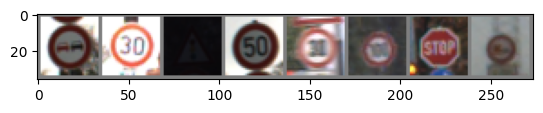

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

# Data Preprocessing and Augmentation
# Resizing images to 32x32 and normalizing pixel values
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

print("Downloading and preparing dataset...")

# Downloading GTSRB Dataset
train_dataset = torchvision.datasets.GTSRB(
    root='./data', split='train', download=True, transform=transform)

test_dataset = torchvision.datasets.GTSRB(
    root='./data', split='test', download=True, transform=transform)

# Splitting training data into Training (80%) and Validation (20%) sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Creating DataLoaders for batch processing
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training Samples: {len(train_set)}")
print(f"Validation Samples: {len(val_set)}")
print(f"Test Samples: {len(test_dataset)}")

# Helper function to visualize images
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display random sample images
dataiter = iter(train_loader)
images, labels = next(dataiter)

print("Sample Traffic Signs:")
imshow(torchvision.utils.make_grid(images[:8]))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Model 1: Baseline Shallow CNN Architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Convolutional Layer 1: 3 input channels -> 6 output filters
        self.conv1 = nn.Conv2d(3, 6, 5)

        # Max Pooling Layer
        self.pool = nn.MaxPool2d(2, 2)

        # Convolutional Layer 2: 6 input channels -> 16 output filters
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Fully Connected Layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)

        # Output Layer: 43 Classes (Traffic Signs)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # Conv -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x))) # Conv -> ReLU -> Pool
        x = torch.flatten(x, 1)              # Flatten for Dense Layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model1 = SimpleCNN().to(device)
print(f"Model running on: {device}")

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

# Training Loop for Model 1
print("Starting training for Model 1 (Baseline)...")
epochs = 10
train_losses = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + Backward + Optimize
        outputs = model1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch + 1} completed. Average Loss: {avg_loss:.4f}')

print('Model 1 training finished.')

Model running on: cpu
Starting training for Model 1 (Baseline)...
Epoch 1 completed. Average Loss: 2.0612
Epoch 2 completed. Average Loss: 0.5358
Epoch 3 completed. Average Loss: 0.2840
Epoch 4 completed. Average Loss: 0.1924
Epoch 5 completed. Average Loss: 0.1405
Epoch 6 completed. Average Loss: 0.1036
Epoch 7 completed. Average Loss: 0.0874
Epoch 8 completed. Average Loss: 0.0674
Epoch 9 completed. Average Loss: 0.0590
Epoch 10 completed. Average Loss: 0.0478
Model 1 training finished.


In [ ]:
# Model 2: Improved CNN Architecture
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()

        # Increased filter capacity (32/64 filters) with Padding to preserve dimensions
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        # Dropout layer to prevent overfitting (randomly zeroes 25% of neurons)
        self.dropout = nn.Dropout(0.25)

        # Adjusted Fully Connected dimensions based on new architecture
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 43)

    def forward(self, x):
        # Layer 1
        x = self.pool(F.relu(self.conv1(x)))
        # Layer 2
        x = self.pool(F.relu(self.conv2(x)))

        # Flattening
        x = torch.flatten(x, 1)

        # Apply Dropout during training
        x = self.dropout(x)

        # Classification Layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model2 = ImprovedCNN().to(device)
print("Model 2 (Improved) initialized.")

# Optimizer for Model 2 (Same learning rate for fair comparison)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

# Training Loop for Model 2
print("Starting training for Model 2 (Improved)...")
train_losses_2 = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer2.zero_grad()
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer2.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses_2.append(avg_loss)
    print(f'Model 2 - Epoch {epoch + 1} completed. Average Loss: {avg_loss:.4f}')

print('Model 2 training finished.')

Model 2 (Improved) initialized.
Starting training for Model 2 (Improved)...
Model 2 - Epoch 1 completed. Average Loss: 1.2684
Model 2 - Epoch 2 completed. Average Loss: 0.1992
Model 2 - Epoch 3 completed. Average Loss: 0.1048
Model 2 - Epoch 4 completed. Average Loss: 0.0616
Model 2 - Epoch 5 completed. Average Loss: 0.0451
Model 2 - Epoch 6 completed. Average Loss: 0.0324
Model 2 - Epoch 7 completed. Average Loss: 0.0365
Model 2 - Epoch 8 completed. Average Loss: 0.0318
Model 2 - Epoch 9 completed. Average Loss: 0.0335
Model 2 - Epoch 10 completed. Average Loss: 0.0185
Model 2 training finished.



--- Final Evaluation on Test Set ---
Model 1 (Baseline) Test Accuracy: %87.31
Model 2 (Improved) Test Accuracy: %87.46

Result: Model 2 outperformed Model 1 by %0.15


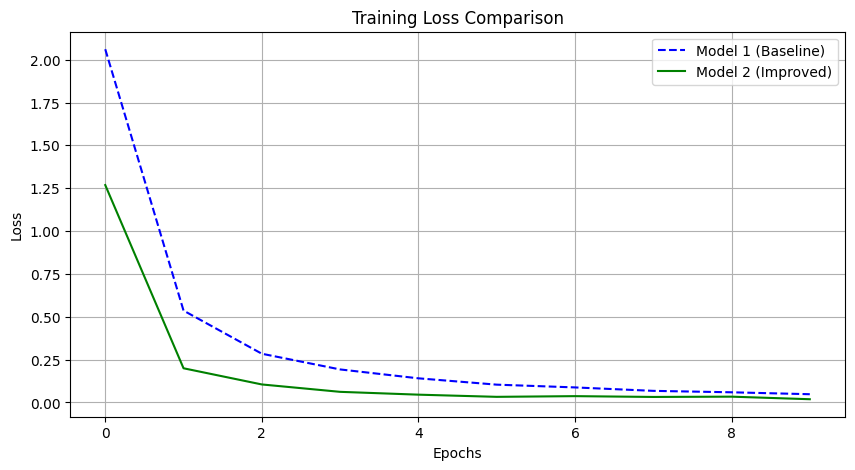

In [ ]:
# Function to evaluate model accuracy on the Test Set
def evaluate_model(model, dataloader, model_name):
    correct = 0
    total = 0
    # No gradient needed for evaluation
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'{model_name} Test Accuracy: %{accuracy:.2f}')
    return accuracy

print("\n--- Final Evaluation on Test Set ---")
acc1 = evaluate_model(model1, test_loader, "Model 1 (Baseline)")
acc2 = evaluate_model(model2, test_loader, "Model 2 (Improved)")

# Comparative Analysis
diff = acc2 - acc1
print(f"\nResult: Model 2 outperformed Model 1 by %{diff:.2f}")

# Plotting Training Loss Comparison
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Model 1 (Baseline)', color='blue', linestyle='--')
plt.plot(train_losses_2, label='Model 2 (Improved)', color='green')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()